In [136]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier


In [27]:

def scaler(X_train, X_test, minmax = False):
    '''
    Arguments: X_train and X_test data
    Optional: minmax (scale between 0 and 1)

    Returns: X_train and X_test either standardized by demeaning, or scaled to 1
    '''
    if minmax == True:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# def get_indices(df):
#     X_full_indices = df.drop(['pt_suc', 'pt_attempt'], axis =1 ).columns
#     return X_full_indices


def splitter(df, target = 'pt_attempt', test_size = .25, random_state = 29, VIF_drop = False, scaled = False, minmax = False):
    '''
    Arguments: The dataframe
    Optional Args: test size, random state, whether to drop a list (determined by VIF correlations)
    whether to scale, whether to use minmax scaling (between 0 and 1)

    Returns:
    X_train, X_test, y_train, y_test, and the feature labels for the columns in X
    '''
    
    _targets = ['pt_attempt', 'pt_suc']
    if VIF_drop == True:
        df = df.drop(vifdrops, axis = 1)
        y = df[target]
        X = df.drop(_targets, axis = 1)
    if VIF_drop == False:
        y = df[target]
        X = df.drop(_targets, axis = 1)
    colnames = X.columns
    idx = colnames.to_numpy()
    feature_labels = np.concatenate((['constant'], idx) )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state= random_state, stratify = y )
    if scaled == True:
        X_train, X_test = scaler(X_train, X_test, minmax = minmax)
    X_train = add_constant(X_train)    
    X_test =  add_constant(X_test)    
    return X_train, X_test, y_train, y_test, feature_labels

def upsampler(X_train, y_train, target = 'pt_attempt'):
    '''
    Args: X_train and y_train
    Optional: what is the target
    Returns: y_train, and X_train with the target rows sampled with replacement to equal 
    the number of non-target rows (makes X_train much bigger)
    '''
    X = pd.concat([X_train, y_train], axis=1) 
    no_coup = X[X[target]==0]
    coup = X[X[target]==1]
    coups_upsampled = resample(coup,
                          replace=True, # sample with replacement
                          n_samples=len(no_coup), # match number in majority class
                          random_state=29)
    upsampled = pd.concat([no_coup, coups_upsampled])
    y_up = upsampled[target]
    X_up = upsampled.drop(target, axis = 1)
    return X_up, y_up

def downsampler(X_train, y_train, target = 'pt_attempt'):
    '''
    Args: X_train and y_train
    Optional: what is the target
    Returns: y_train, and X_train with the non-target rows sampled with replacement to equal 
    the number of target rows (makes X_train much smaller)

    '''
    X = pd.concat([X_train, y_train], axis=1) 
    no_coup = X[X[target]==0]
    coup = X[X[target]==1]
    coups_downsampled = resample(no_coup,
                          replace=True, # sample with replacement
                          n_samples=len(coup), # match number in majority class
                          random_state=29)
    downsampled = pd.concat([coup, coups_downsampled])
    y_down = downsampled[target]
    X_down = downsampled.drop(target, axis = 1)
    return X_down, y_down

def smoter(X_train, y_train, ratio = 1.0):
    '''
    Args: X_train and y_train
    Optional: ratio
    Returns: y_train, and X_train with new target rows synthetically added to equal 
    the number of target rows (makes X_train much smaller) (or a different)
    '''
    sm = SMOTE(random_state=29, ratio=ratio)
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
    return X_train_sm, y_train_sm



def data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 29, VIF_drop = False, scaled = False, minmax = False, resampler = None, sample_ratio = 1):
    '''
    Processes the onehot encoded dataframe to prepare it for modelling, with optional arguments 
    to drop collinear columns, resample, and scale.

    Args: dataframe, 
    optional: target columns, ratio for test train split, random state,
    whether to drop the vif_list, whether to scale, whether to use minmax (only makes sense if scaled = True),
    whether to resample, and what ratio to resample at (only currenly implemented with SMOTE)
    R

    '''
    X_train, X_test, y_train, y_test, feature_labels = splitter(df, target = 'pt_attempt', test_size = .25, 
                                                random_state = 29, VIF_drop = VIF_drop, scaled = scaled, minmax = minmax)
    if resampler == 'upsample':
        X_train, y_train = upsampler(X_train, y_train)
    if resampler == 'downsample':
        X_train, y_train = downsampler(X_train, y_train)
    if resampler == 'smote':
        X_train, y_train = smoter(X_train, y_train, ratio = sample_ratio)
    return X_train, X_test, y_train, y_test, feature_labels

def get_feature_weights(model, feature_labels):
    '''
    returns coefficients for features in a model (intended for logistic regression) 
    args: model, feature_labels
    returns: a sorted series in ascending order of feature weights.
    '''
    d_log_vals = {}
    for idx, feat in enumerate(model.coef_[0]):
        d_log_vals[feature_labels[idx]] = feat  
    s_log_vals = (pd.Series(d_log_vals)).sort_values()
    return s_log_vals

def metric_test(model, X_test, y_test):
    '''
    Prints out the accuracy, recall, precision, and f1 score for the 
    fit model when it predicts on the test data
    '''
    preds = model.predict(X_test)
    print('accuracy = ' + str(accuracy_score(y_test, preds)))
    print('recall = ' + str(recall_score(y_test, preds)))
    print('precision = ' + str(precision_score(y_test, preds)))
    print('f1 score = ' + str(f1_score(y_test, preds)))
    #print('r2_score = ' + str(r2_score(y_test, preds)))


def fit_test_model(model, X_train, X_test, y_train, y_test, indices, do_metric_test = True, get_features = False):
    '''
    fits a model to the training data, with the option argument to print out the feature weights
    '''
    model.fit(X_train, y_train)
    if do_metric_test == True:
        metric_test(model, X_test, y_test)
    if get_features == True:
        features = get_feature_weights(model, indices)
        print(features)
    return model

def variance_inflation_factors(X):
    '''
    calculates VIF values for the X dataset, inteded to be used iteratively to reduce 
    collinearity by dropping values from X and rechecking the values
    '''
    # X = add_constant(X)
    vifs = pd.Series(
        [1 / (1. - OLS(X[col].values, 
                       X.loc[:, X.columns != col].values).fit().rsquared) 
         for col in X],
        index=X.columns,
        name='VIF'
    )
    return vifs.sort_values()

In [28]:
df = pd.read_pickle('../data/year_agg_dum.pkl')

In [177]:
year_agg = pd.read_pickle('../data/year_agg.pkl')

In [178]:
year_agg

,ccode,country,leader,year,month,elected,age,male,militarycareer,tenure_months,...,nochange_recent,delayed,lastelection,loss,irregular,prev_conflict,precip,yearcode,coupyear,coupsuc
0,2.0,USA,Truman,1950.0,1.0,1.0,66.0,1,0.0,58.0,...,0.0,0.0,2.639057,5.327876,7.565793,0.0,-0.069058,21950.0,False,False
1,2.0,USA,Truman,1951.0,1.0,1.0,67.0,1,0.0,70.0,...,0.0,0.0,3.258097,5.384495,7.571989,0.0,-0.202572,21951.0,False,False
2,2.0,USA,Truman,1952.0,1.0,1.0,68.0,1,0.0,82.0,...,0.0,0.0,3.637586,5.438079,7.578145,0.0,0.394373,21952.0,False,False
3,2.0,USA,Truman,1953.0,1.0,1.0,69.0,1,0.0,94.0,...,0.0,0.0,1.098612,1.098612,7.584265,0.0,-0.665329,21953.0,False,False
4,2.0,USA,Eisenhower,1953.0,1.0,1.0,63.0,1,1.0,1.0,...,0.0,0.0,1.098612,1.098612,7.584265,0.0,-0.665329,21953.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364,990.0,Samoa,Tuilaepa Sailele Malielegaoi,2016.0,1.0,1.0,71.0,1,0.0,206.0,...,0.0,0.0,4.077538,5.817111,6.476973,0.0,-0.391420,9902016.0,False,False
11365,990.0,Samoa,Tuilaepa Sailele Malielegaoi,2017.0,1.0,1.0,72.0,1,0.0,218.0,...,0.0,0.0,2.397895,5.852202,6.495265,0.0,0.025780,9902017.0,False,False
11366,990.0,Samoa,Tuilaepa Sailele Malielegaoi,2018.0,1.0,1.0,73.0,1,0.0,230.0,...,0.0,0.0,3.135494,5.886104,6.513230,0.0,0.278135,9902018.0,False,False
11367,990.0,Samoa,Tuilaepa Sailele Malielegaoi,2019.0,1.0,1.0,74.0,1,0.0,242.0,...,0.0,0.0,3.555348,5.918894,6.530878,0.0,0.210903,9902019.0,False,False


In [180]:
df2 = pd.read_pickle('../data/df_one_hot_num.pkl')

In [184]:
df3 = pd.read_pickle('../data/yearly_nmc_trade.pkl')

In [182]:
df2.columns

Index(['year', 'month', 'elected', 'age', 'male', 'militarycareer',
       'tenure_months', 'anticipation', 'ref_ant', 'leg_ant', 'exec_ant',
       'irreg_lead_ant', 'election_now', 'election_recent', 'leg_recent',
       'exec_recent', 'lead_recent', 'ref_recent', 'direct_recent',
       'indirect_recent', 'victory_recent', 'defeat_recent', 'change_recent',
       'nochange_recent', 'delayed', 'lastelection', 'loss', 'irregular',
       'prev_conflict', 'pt_suc', 'pt_attempt', 'precip', 'imports', 'exports',
       'milex', 'milper', 'irst', 'pec', 'upop', 'cinc', 'population',
       'Dominant Party', 'Foreign/Occupied', 'Indirect Military', 'Military',
       'Military-Personal', 'Monarchy', 'Oligarchy', 'Party-Military',
       'Party-Personal', 'Party-Personal-Military Hybrid',
       'Personal Dictatorship', 'Presidential Democracy',
       'Provisional - Civilian', 'Provisional - Military', 'Warlordism',
       'trade balance', 'urban_percent', 'mil_percent'],
      dtype='obje

In [185]:
df3.columns

Index(['ccode', 'country', 'leader', 'year', 'month', 'elected', 'age', 'male',
       'militarycareer', 'tenure_months', 'government', 'anticipation',
       'ref_ant', 'leg_ant', 'exec_ant', 'irreg_lead_ant', 'election_now',
       'election_recent', 'leg_recent', 'exec_recent', 'lead_recent',
       'ref_recent', 'direct_recent', 'indirect_recent', 'victory_recent',
       'defeat_recent', 'change_recent', 'nochange_recent', 'delayed',
       'lastelection', 'loss', 'irregular', 'prev_conflict', 'precip',
       'imports', 'exports', 'milex', 'milper', 'irst', 'pec', 'upop', 'cinc',
       'pt_attempt', 'pt_suc', 'Dominant Party', 'Foreign/Occupied',
       'Indirect Military', 'Military', 'Military-Personal', 'Monarchy',
       'Oligarchy', 'Party-Military', 'Party-Personal',
       'Party-Personal-Military Hybrid', 'Personal Dictatorship',
       'Presidential Democracy', 'Provisional - Civilian',
       'Provisional - Military', 'Warlordism'],
      dtype='object')

In [188]:
df3 = df3.drop(['country', 'leader', 'government'], axis = 1)

In [31]:
df['pt_attempt'] = df['coupyear']

In [32]:
df['pt_suc'] = df['coupsuc']

In [33]:
df = df.drop(['coupyear', 'coupsuc', 'ccode', 'country', 'leader', 'year', 'month', 'government'], axis =1)

In [34]:
df

,elected,age,male,militarycareer,tenure_months,anticipation,ref_ant,leg_ant,exec_ant,irreg_lead_ant,...,Party-Military,Party-Personal,Party-Personal-Military Hybrid,Personal Dictatorship,Presidential Democracy,Provisional - Civilian,Provisional - Military,Warlordism,pt_attempt,pt_suc
0,1.0,66.0,1,0.0,58.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,False
1,1.0,67.0,1,0.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,False
2,1.0,68.0,1,0.0,82.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,False
3,1.0,69.0,1,0.0,94.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,False
4,1.0,63.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11364,1.0,71.0,1,0.0,206.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,False,False
11365,1.0,72.0,1,0.0,218.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,False,False
11366,1.0,73.0,1,0.0,230.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,False,False
11367,1.0,74.0,1,0.0,242.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,False,False


In [35]:
df.columns

Index(['elected', 'age', 'male', 'militarycareer', 'tenure_months',
       'anticipation', 'ref_ant', 'leg_ant', 'exec_ant', 'irreg_lead_ant',
       'election_now', 'election_recent', 'leg_recent', 'exec_recent',
       'lead_recent', 'ref_recent', 'direct_recent', 'indirect_recent',
       'victory_recent', 'defeat_recent', 'change_recent', 'nochange_recent',
       'delayed', 'lastelection', 'loss', 'irregular', 'prev_conflict',
       'precip', 'yearcode', 'Dominant Party', 'Foreign/Occupied',
       'Indirect Military', 'Military', 'Military-Personal', 'Monarchy',
       'Oligarchy', 'Party-Military', 'Party-Personal',
       'Party-Personal-Military Hybrid', 'Personal Dictatorship',
       'Presidential Democracy', 'Provisional - Civilian',
       'Provisional - Military', 'Warlordism', 'pt_attempt', 'pt_suc'],
      dtype='object')

In [198]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df3, target = 'pt_attempt', test_size = .25, random_state = 100, VIF_drop = False, scaled = False, minmax = False, resampler = 'upsample', sample_ratio = 1)


/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [193]:
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 3)

In [194]:
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [195]:
clf_preds = clf.predict_proba(X_test)

In [196]:
clf_fpr, clf_tpr, thresholds = metrics.roc_curve(y_test, clf_preds[:,1])

In [160]:
dt = DecisionTreeClassifier()

In [161]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [162]:
metric_test(dt, X_test, y_test)


accuracy = 0.937741822018994
recall = 0.102803738317757
precision = 0.11956521739130435
f1 score = 0.11055276381909548


In [163]:
dt_preds = dt.predict_proba(X_test)

In [164]:
dt_fpr, dt_tpr, thresholds = metrics.roc_curve(y_test, dt_preds[:,1])

In [165]:
clf_fpr, clf_tpr, thresholds = metrics.roc_curve(y_test, clf_preds[:,1])

In [166]:
print('====yearly df=====')
metric_test(clf, X_test, y_test)


====yearly df=====
accuracy = 0.6795638410130144
recall = 0.7289719626168224
precision = 0.08125
f1 score = 0.14620431115276478


In [167]:
print('====df2====')
metric_test(clf, X_test, y_test)

====df2====
accuracy = 0.6795638410130144
recall = 0.7289719626168224
precision = 0.08125
f1 score = 0.14620431115276478


In [17]:
scores = clf.predict_proba(X_test)[:,1]

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

In [103]:
xgclf = xgb.XGBClassifier(objective = 'reg:logistic')

In [168]:
xgclf2 = xgb.XGBClassifier(objective = 'reg:logistic')

In [56]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [199]:
xgclf2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='reg:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [191]:
xg_preds = xgclf2.predict_proba(X_test)

In [100]:
bin_preds = xgclf2.predict(X_test)

In [200]:
metric_test(xgclf2, X_test, y_test)

accuracy = 0.7954545454545454
recall = 0.7029702970297029
precision = 0.1446028513238289
f1 score = 0.23986486486486486


In [88]:
from sklearn.metrics import roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt

In [80]:
preds[:,1]

array([0.05040842, 0.00827473, 0.00586543, ..., 0.00238031, 0.03477336,
       0.00533398], dtype=float32)

In [201]:
roc_auc_score(y_test, xg_preds[:,1])

0.824324643040769

In [202]:
roc_auc_score(y_test, clf_preds[:,1])

0.7934660069151269

In [174]:
xg_fpr, xg_tpr, thresholds = metrics.roc_curve(y_test, xg_preds[:,1])

In [113]:
thresholds

array([1.9279029e+00, 9.2790300e-01, 9.2248660e-01, ..., 1.0617145e-03,
       1.0131568e-03, 7.1063376e-04], dtype=float32)

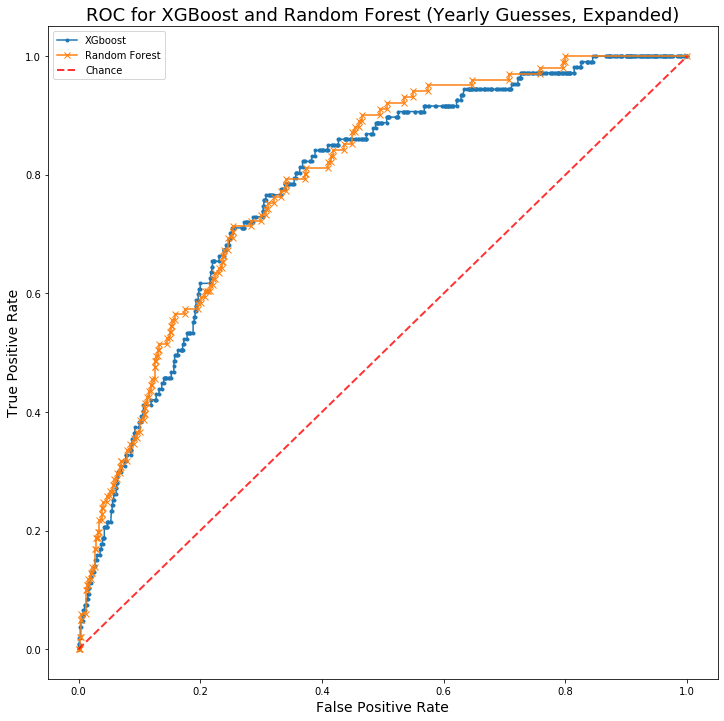

In [197]:
fig, ax = plt.subplots(figsize = (12, 12))

ax.plot(xg_fpr, xg_tpr, marker='.', label='XGboost')
ax.plot(clf_fpr, clf_tpr, marker='x', label='Random Forest')
#ax.plot(dt_fpr, dt_tpr, marker='+', label='Decision Tree')



# axis labels
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title('ROC for XGBoost and Random Forest (Yearly Guesses, Expanded)', fontsize = 18)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
# show the legend
ax.legend()
# show the plot
fig.savefig('../images/ROC_xg_rf_yearly_expanded.png')

In [116]:
preds[:,1].argsort()

array([10259, 10605,  6509, ...,  8051,  3242, 22008])

In [119]:
preds[:,1][22008]

0.927903

In [120]:
len(preds)

26502

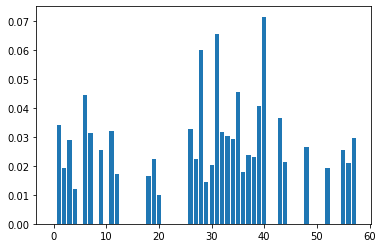

In [153]:

plt.bar(range(len(xgclf2.feature_importances_)), xgclf2.feature_importances_)
plt.show()